In [1]:
#Read Files
import pandas as pd
import numpy as np

random_df = pd.read_csv('random_tweets_processed.csv')
depressed_df = pd.read_csv('depressive_tweets_processed.csv')
random_df.tweet = random_df.tweet.astype(str)
depressed_df.tweet = depressed_df.tweet.astype(str)
random_df.dropna(inplace=True)
depressed_df.dropna(inplace=True)

np.random.seed(1234)

In [2]:
#GoogleNews Pretrained Embeddings
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [3]:
#List of tweets
X_r = np.array(random_df['tweet'].tolist())
X_d = np.array(depressed_df['tweet'].tolist())

In [4]:
#Assigning Labels and Split Data
d_rows = len(X_d)
r_rows = len(X_r)

labels_d = np.array([1] * d_rows)
labels_r = np.array([0] * r_rows)

perm_d = np.random.permutation(d_rows)
train_d_idx = perm_d[:int((0.7)*(d_rows))]
val_d_idx = perm_d[int((0.7)*(d_rows)) : int((0.85)*(d_rows))]
test_d_idx = perm_d[int((0.85)*(d_rows)):]

perm_r = np.random.permutation(r_rows)
train_r_idx = perm_r[:int((0.7)*(r_rows))]
val_r_idx = perm_r[int((0.7)*(r_rows)) : int((0.85)*(r_rows))]
test_r_idx = perm_r[int((0.85)*(r_rows)):]

X_train = np.concatenate((X_d[train_d_idx], X_r[train_r_idx]))
labels_train = np.concatenate((labels_d[train_d_idx], labels_r[train_r_idx]))
X_val = np.concatenate((X_d[val_d_idx], X_r[val_r_idx]))
labels_val = np.concatenate((labels_d[val_d_idx], labels_r[val_r_idx]))
X_test = np.concatenate((X_d[test_d_idx], X_r[test_r_idx]))
labels_test = np.concatenate((labels_d[test_d_idx], labels_r[test_r_idx]))

perm_train = np.random.permutation(len(X_train))
X_train = X_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(X_test))
X_test = X_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(X_val))
X_val = X_val[perm_val]
labels_val = labels_val[perm_val]

In [5]:
#Tokenize on Train Data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000, oov_token=True)
tokenizer.fit_on_texts(X_train)

import pickle

#Save Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
#Convert Texts to Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [7]:
#Pad Sequences to length of 120 
data_train = pad_sequences(train_sequences, maxlen=120)
data_val = pad_sequences(val_sequences, maxlen=120)
data_test = pad_sequences(test_sequences, maxlen=120)

In [8]:
#Number of tokens in vocabulary
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 10197 unique tokens


In [9]:
#Create Embedding matrix
nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words+1, 300))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < 20000:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [10]:
#Import Keras Dependencies
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPooling1D, Flatten
from keras.layers import Activation, MaxPooling1D, BatchNormalization, GRU, Bidirectional, SpatialDropout1D
from attention import Attention

### Baseline (Logistic Regression)

In [11]:
X_train = np.concatenate((data_train, data_val))
y_train = np.concatenate((labels_train, labels_val))

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train, y_train)
accuracy = logreg.score(data_test, labels_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 81.34%


In [12]:
from sklearn.metrics import classification_report
labels_pred = logreg.predict(data_test)
print(classification_report(labels_pred, labels_test))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90      1479
           1       0.04      0.81      0.09        16

    accuracy                           0.81      1495
   macro avg       0.52      0.81      0.49      1495
weighted avg       0.99      0.81      0.89      1495



### LSTM

In [13]:
lstm_model = Sequential()

lstm_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=120, trainable=False))
lstm_model.add(LSTM(300))
lstm_model.add(Dropout(0.6))
lstm_model.add(Dense(1, activation='sigmoid'))

In [14]:
lstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 300)          3059400   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 3,780,901
Trainable params: 721,501
Non-trainable params: 3,059,400
_________________________________________________________________
None


In [15]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = lstm_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 70s 321ms/step - loss: 0.2771 - acc: 0.8985 - val_loss: 0.2010 - val_acc: 0.9398
Epoch 2/30
218/218 [==============================] - 72s 332ms/step - loss: 0.1813 - acc: 0.9343 - val_loss: 0.1714 - val_acc: 0.9492
Epoch 3/30
218/218 [==============================] - 74s 341ms/step - loss: 0.1621 - acc: 0.9424 - val_loss: 0.1616 - val_acc: 0.9465
Epoch 4/30
218/218 [==============================] - 74s 339ms/step - loss: 0.1458 - acc: 0.9480 - val_loss: 0.1676 - val_acc: 0.9418
Epoch 5/30
218/218 [==============================] - 75s 343ms/step - loss: 0.2242 - acc: 0.9224 - val_loss: 0.1873 - val_acc: 0.9505


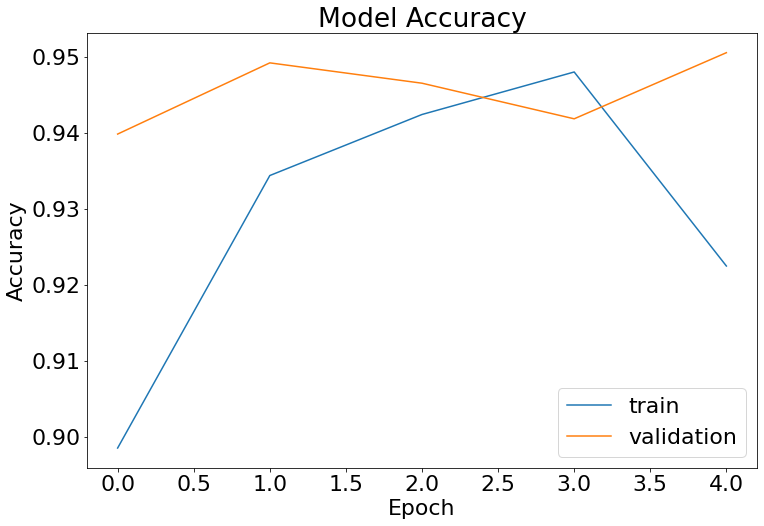

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

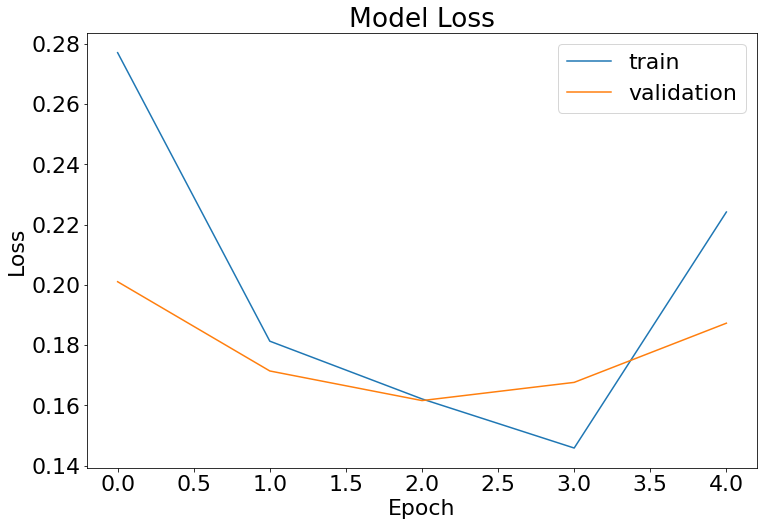

In [17]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score

labels_pred = lstm_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 94.38%


In [19]:
print(classification_report(labels_test, labels_pred))
lstm_model.save('lstm.h5')

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1206
           1       0.94      0.76      0.84       289

    accuracy                           0.94      1495
   macro avg       0.94      0.87      0.90      1495
weighted avg       0.94      0.94      0.94      1495



### CNN

In [20]:
cnn_model = Sequential()

cnn_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=120, trainable=False))
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [21]:
cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 300)          3059400   
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,252,829
Trainable params: 193,429
Non-trainable params: 3,059,400
______________________________________

In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = cnn_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 4s 19ms/step - loss: 0.2787 - acc: 0.8939 - val_loss: 0.1549 - val_acc: 0.9518
Epoch 2/30
218/218 [==============================] - 4s 20ms/step - loss: 0.1538 - acc: 0.9445 - val_loss: 0.1403 - val_acc: 0.9585
Epoch 3/30
218/218 [==============================] - 4s 20ms/step - loss: 0.1205 - acc: 0.9576 - val_loss: 0.1365 - val_acc: 0.9552
Epoch 4/30
218/218 [==============================] - 4s 20ms/step - loss: 0.0927 - acc: 0.9656 - val_loss: 0.1371 - val_acc: 0.9585
Epoch 5/30
218/218 [==============================] - 5s 21ms/step - loss: 0.0732 - acc: 0.9722 - val_loss: 0.1465 - val_acc: 0.9552


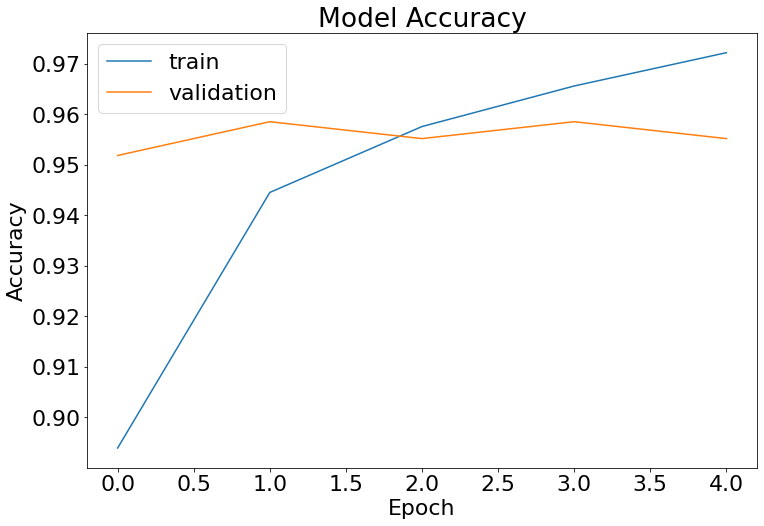

In [23]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

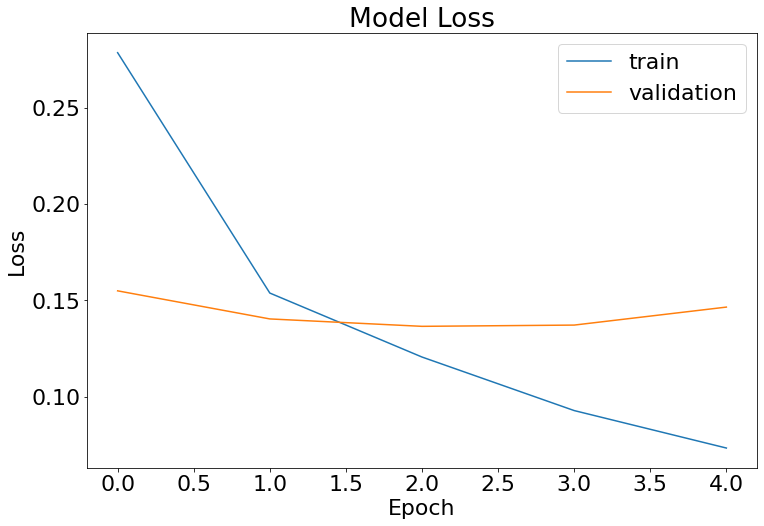

In [24]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [25]:
labels_pred = cnn_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 94.58%


In [26]:
print(classification_report(labels_test, labels_pred))
cnn_model.save('cnn.h5')

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1206
           1       0.93      0.78      0.85       289

    accuracy                           0.95      1495
   macro avg       0.94      0.88      0.91      1495
weighted avg       0.95      0.95      0.94      1495



### LSTM + CNN

In [28]:
lstm_cnn_model = Sequential()

lstm_cnn_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=120, trainable=False))

lstm_cnn_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

lstm_cnn_model.add(MaxPooling1D(pool_size=2))

lstm_cnn_model.add(Dropout(0.6))

lstm_cnn_model.add(LSTM(300))

lstm_cnn_model.add(Dropout(0.2))

lstm_cnn_model.add(Dense(1, activation='sigmoid'))

In [29]:
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 300)          3059400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               438000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = lstm_cnn_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 25s 115ms/step - loss: 0.3190 - acc: 0.8677 - val_loss: 0.2793 - val_acc: 0.8963
Epoch 2/30
218/218 [==============================] - 26s 118ms/step - loss: 0.1966 - acc: 0.9265 - val_loss: 0.1725 - val_acc: 0.9411
Epoch 3/30
218/218 [==============================] - 26s 121ms/step - loss: 0.1746 - acc: 0.9319 - val_loss: 0.1551 - val_acc: 0.9498
Epoch 4/30
218/218 [==============================] - 26s 119ms/step - loss: 0.1700 - acc: 0.9323 - val_loss: 0.1527 - val_acc: 0.9478
Epoch 5/30
218/218 [==============================] - 26s 121ms/step - loss: 0.1521 - acc: 0.9382 - val_loss: 0.1578 - val_acc: 0.9398
Epoch 6/30
218/218 [==============================] - 27s 122ms/step - loss: 0.1363 - acc: 0.9429 - val_loss: 0.1505 - val_acc: 0.9452
Epoch 7/30
218/218 [==============================] - 26s 120ms/step - loss: 0.1278 - acc: 0.9485 - val_loss: 0.1584 - val_acc: 0.9371
Epoch 8/30
218/218 [==============================] - 2

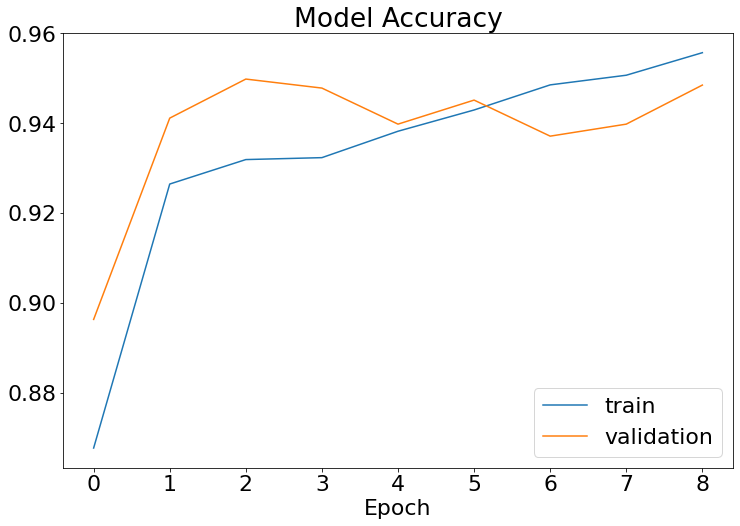

In [31]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

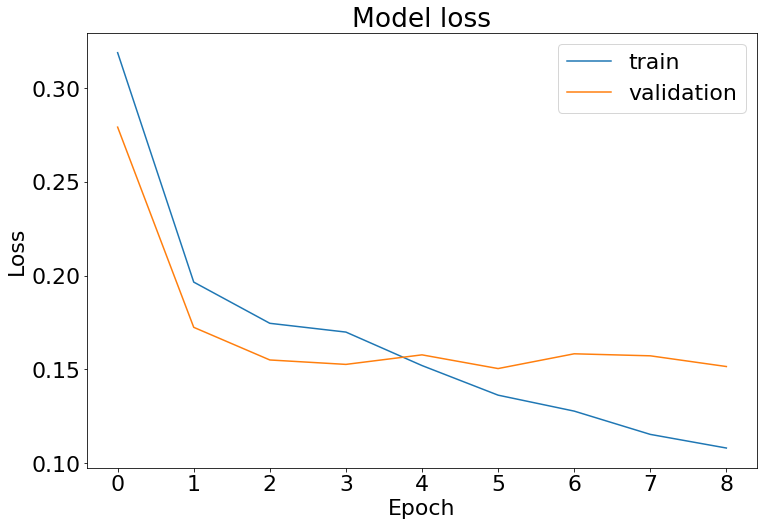

In [32]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [33]:
labels_pred = lstm_cnn_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 93.98%


In [34]:
print(classification_report(labels_test, labels_pred))
lstm_cnn_model.save('lstm_cnn.h5')

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1206
           1       0.89      0.79      0.83       289

    accuracy                           0.94      1495
   macro avg       0.92      0.88      0.90      1495
weighted avg       0.94      0.94      0.94      1495



### BiLSTM

In [36]:
bilstm_model = Sequential()

bilstm_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=120, trainable=False))
bilstm_model.add(Bidirectional(LSTM(300)))
bilstm_model.add(Dropout(0.6))
bilstm_model.add(Dense(1, activation='sigmoid'))

In [37]:
bilstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(bilstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 300)          3059400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dropout_7 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 601       
Total params: 4,502,401
Trainable params: 1,443,001
Non-trainable params: 3,059,400
_________________________________________________________________
None


In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = bilstm_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 148s 680ms/step - loss: 0.2844 - acc: 0.8912 - val_loss: 0.1926 - val_acc: 0.9472
Epoch 2/30
218/218 [==============================] - 152s 700ms/step - loss: 0.1883 - acc: 0.9323 - val_loss: 0.1607 - val_acc: 0.9498
Epoch 3/30
218/218 [==============================] - 165s 755ms/step - loss: 0.2955 - acc: 0.8942 - val_loss: 0.4447 - val_acc: 0.8187
Epoch 4/30
218/218 [==============================] - 164s 753ms/step - loss: 0.3423 - acc: 0.8615 - val_loss: 0.1738 - val_acc: 0.9465


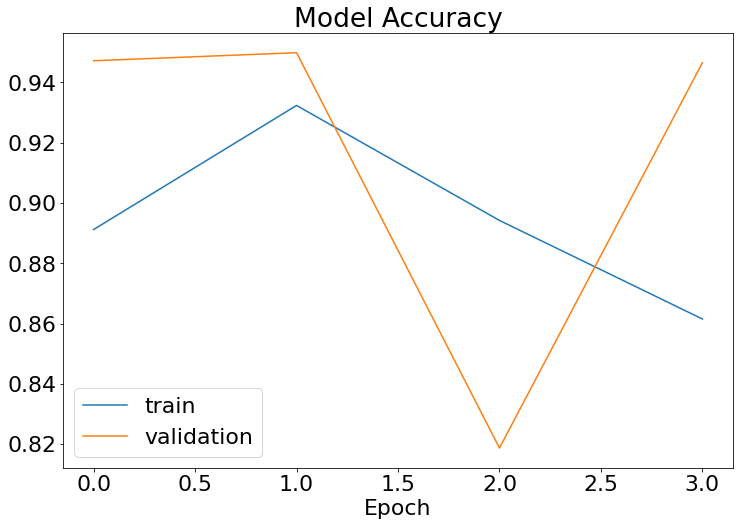

In [39]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

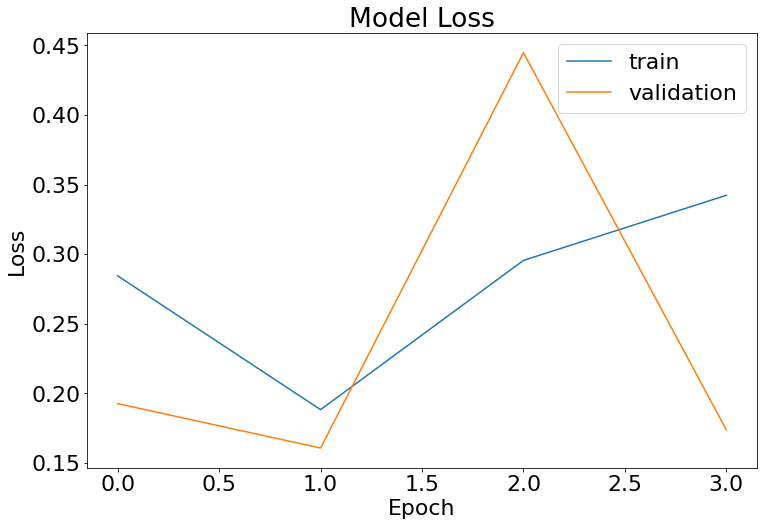

In [40]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [41]:
labels_pred = bilstm_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 93.38%


In [42]:
print(classification_report(labels_test, labels_pred))
bilstm_model.save('bilstm.h5')

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1206
           1       0.93      0.71      0.81       289

    accuracy                           0.93      1495
   macro avg       0.93      0.85      0.88      1495
weighted avg       0.93      0.93      0.93      1495



### GRU

In [45]:
gru_model = Sequential()

gru_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=120, trainable=False))
gru_model.add(SpatialDropout1D(0.5))
gru_model.add(Bidirectional(GRU(300)))
gru_model.add(Dropout(0.6))
gru_model.add(Dense(1, activation='sigmoid'))

In [46]:
gru_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 300)          3059400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 120, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1083600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 601       
Total params: 4,143,601
Trainable params: 1,084,201
Non-trainable params: 3,059,400
_________________________________________________________________
None


In [47]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = gru_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 124s 569ms/step - loss: 0.3149 - acc: 0.8826 - val_loss: 0.1776 - val_acc: 0.9458
Epoch 2/30
218/218 [==============================] - 135s 619ms/step - loss: 0.2230 - acc: 0.9200 - val_loss: 0.1778 - val_acc: 0.9505
Epoch 3/30
218/218 [==============================] - 135s 619ms/step - loss: 0.2006 - acc: 0.9286 - val_loss: 0.1639 - val_acc: 0.9512
Epoch 4/30
218/218 [==============================] - 125s 575ms/step - loss: 0.1877 - acc: 0.9333 - val_loss: 0.1671 - val_acc: 0.9458
Epoch 5/30
218/218 [==============================] - 134s 615ms/step - loss: 0.1806 - acc: 0.9366 - val_loss: 0.1516 - val_acc: 0.9525
Epoch 6/30
218/218 [==============================] - 131s 600ms/step - loss: 0.3446 - acc: 0.8736 - val_loss: 0.1629 - val_acc: 0.9498
Epoch 7/30
218/218 [==============================] - 132s 605ms/step - loss: 0.2075 - acc: 0.9270 - val_loss: 0.1564 - val_acc: 0.9505


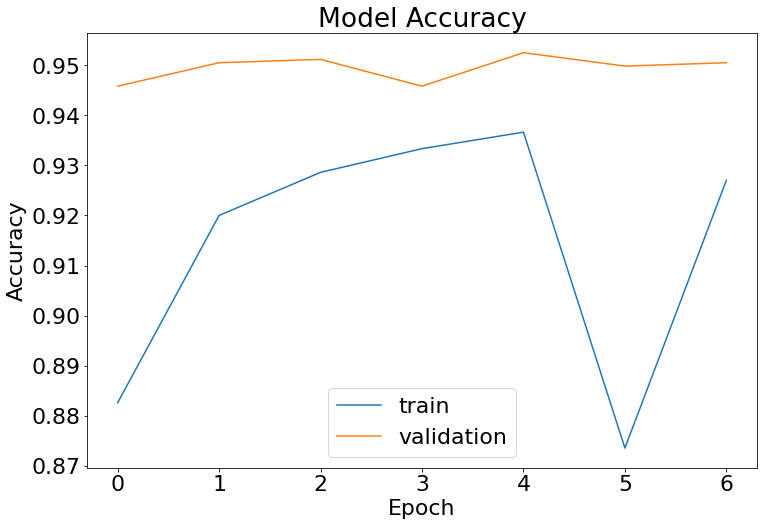

In [48]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

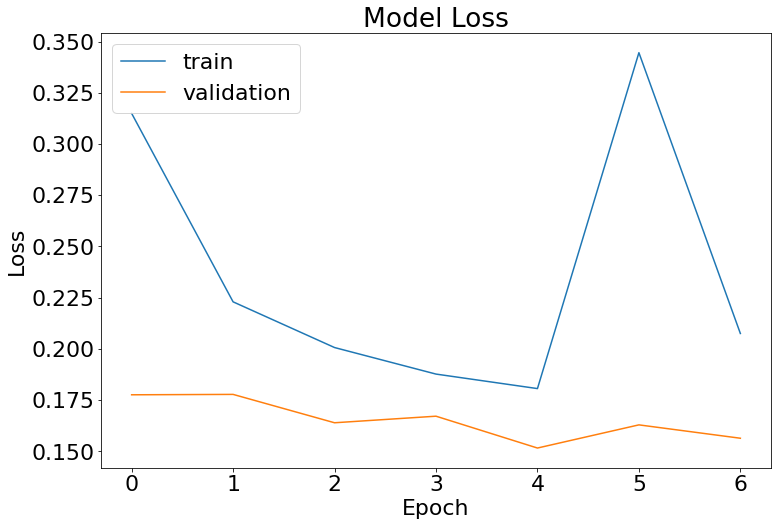

In [49]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [50]:
labels_pred = gru_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 93.44%


In [51]:
print(classification_report(labels_test, labels_pred))
gru_model.save('gru.h5')

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1206
           1       0.98      0.68      0.80       289

    accuracy                           0.93      1495
   macro avg       0.95      0.84      0.88      1495
weighted avg       0.94      0.93      0.93      1495



### Attention-Based BiLSTM+CNN Model

In [52]:
attention_model = Sequential()

attention_model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=120, trainable=False))

attention_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

attention_model.add(MaxPooling1D(pool_size=2))

attention_model.add(Dropout(0.6))

attention_model.add(Bidirectional(LSTM(300, return_sequences=True)))

attention_model.add(Attention())

attention_model.add(Dense(1, activation='sigmoid'))

In [53]:
attention_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(attention_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 300)          3059400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 64)           38464     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 600)           876000    
_________________________________________________________________
attention_score_vec (Dense)  (None, 60, 600)           360000    
_________________________________________________________________
last_hidden_state (Lambda)   (None, 600)              

In [54]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2)

hist = attention_model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=30, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/30
218/218 [==============================] - 60s 274ms/step - loss: 0.4759 - acc: 0.8168 - val_loss: 0.3870 - val_acc: 0.8602
Epoch 2/30
218/218 [==============================] - 61s 280ms/step - loss: 0.3550 - acc: 0.8521 - val_loss: 0.2745 - val_acc: 0.8896
Epoch 3/30
218/218 [==============================] - 65s 297ms/step - loss: 0.2457 - acc: 0.9027 - val_loss: 0.1687 - val_acc: 0.9478
Epoch 4/30
218/218 [==============================] - 59s 272ms/step - loss: 0.1852 - acc: 0.9295 - val_loss: 0.1556 - val_acc: 0.9532
Epoch 5/30
218/218 [==============================] - 60s 274ms/step - loss: 0.1610 - acc: 0.9392 - val_loss: 0.1493 - val_acc: 0.9438
Epoch 6/30
218/218 [==============================] - 61s 280ms/step - loss: 0.1597 - acc: 0.9388 - val_loss: 0.1586 - val_acc: 0.9405
Epoch 7/30
218/218 [==============================] - 64s 294ms/step - loss: 0.1596 - acc: 0.9386 - val_loss: 0.1457 - val_acc: 0.9431
Epoch 8/30
218/218 [==============================] - 6

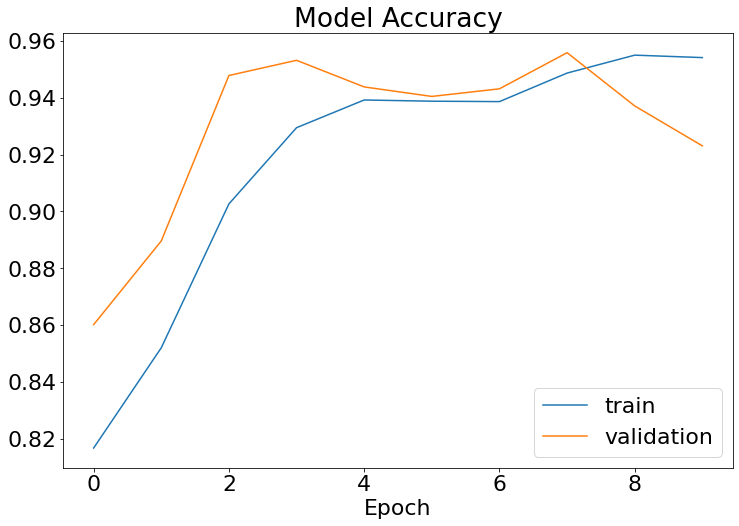

In [55]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

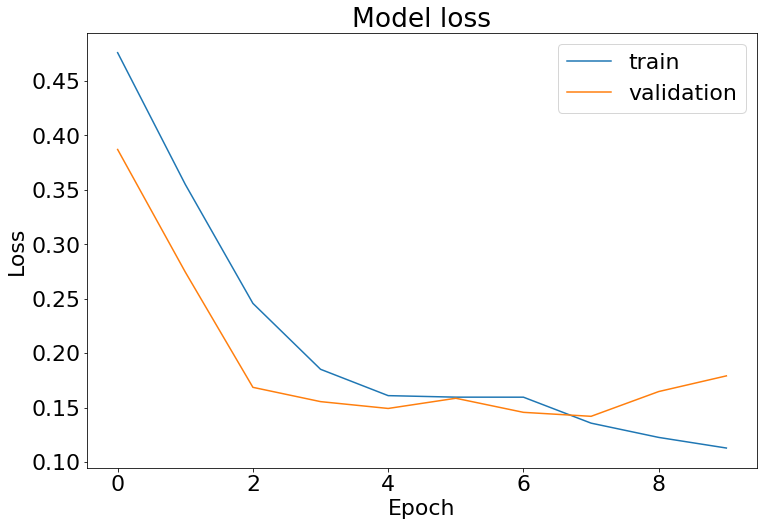

In [56]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [57]:
labels_pred = attention_model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 92.64%


In [58]:
print(classification_report(labels_test, labels_pred))
attention_model.save('attention.h5')

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1206
           1       0.79      0.85      0.82       289

    accuracy                           0.93      1495
   macro avg       0.87      0.90      0.89      1495
weighted avg       0.93      0.93      0.93      1495

